# week 2: Two-View Structure from Motion


**Group 32**

**Members:**
- M. Walid Khalid (26100259)
- Sarmad Sultan (26100179)

---

## 1. Setup and Imports

In [1]:

!pip install opencv-python numpy matplotlib pillow open3d


Defaulting to user installation because normal site-packages is not writeable


ERROR: Could not find a version that satisfies the requirement open3d (from versions: none)
ERROR: No matching distribution found for open3d


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
from PIL import Image
from PIL.ExifTags import TAGS

import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

## 2. Load Input Images

Load your two images that were captured with camera movement (parallax), not just rotation.

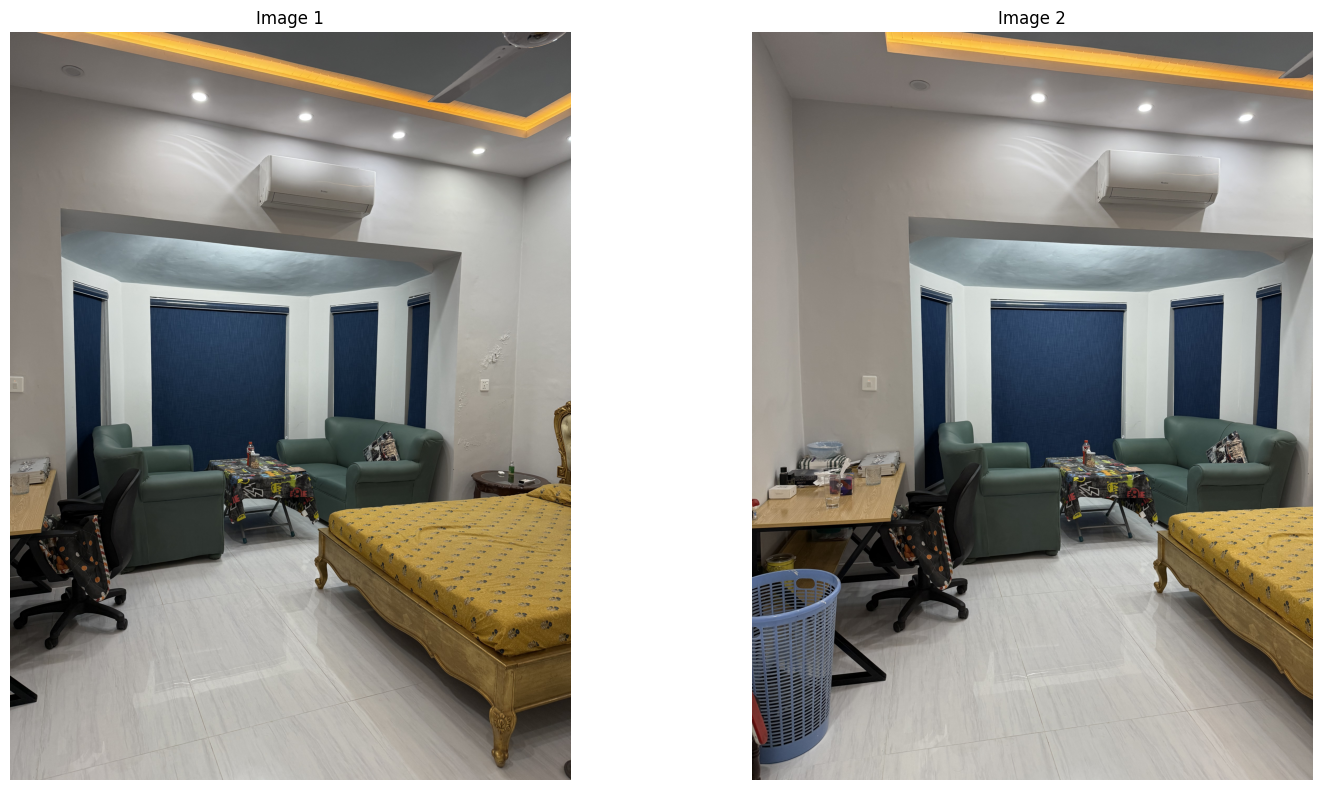

In [3]:
IMAGE1_PATH = './images/IMG_2153.jpeg'
IMAGE2_PATH = './images/IMG_2154.jpeg'

img1 = cv2.imread(IMAGE1_PATH)
img2 = cv2.imread(IMAGE2_PATH)

if img1 is None or img2 is None:
    raise ValueError("Failed to load images. Check your file paths.")

img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

axes[0].imshow(img1_rgb)
axes[0].set_title('Image 1')
axes[0].axis('off')

axes[1].imshow(img2_rgb)
axes[1].set_title('Image 2')
axes[1].axis('off')

plt.tight_layout()
plt.show()

## 3. Camera Intrinsic Matrix K

We'll try to extract camera parameters from EXIF data first, then fall back to a simplified approximation.

In [4]:
def extract_exif_focal_length(image_path):
  image = Image.open(image_path)
  exif_data = image._getexif()

  if exif_data is None:
      return None, None

  focal_length_mm = None
  sensor_width_mm = None

  for tag, value in exif_data.items():
      tag_name = TAGS.get(tag, tag)

      if tag_name == 'FocalLength':
        focal_length_mm = float(value)
      elif tag_name == 'FocalLengthIn35mmFilm':
          focal_length_35mm = float(value)
          sensor_width_mm = 36.0

  return focal_length_mm, sensor_width_mm



def compute_intrinsic_matrix(image_path, image_shape):
    height, width = image_shape[:2]

    focal_mm, sensor_width_mm = extract_exif_focal_length(image_path)

    fx = (focal_mm / sensor_width_mm) * width
    fy = fx  #we assumed square pixels for this calculation - Group32
    print(f"focal_length={focal_mm}mm, sensor_width={sensor_width_mm}mm")

    cx = width / 2.0
    cy = height / 2.0

    K = np.array([
        [fx, 0,  cx],
        [0,  fy, cy],
        [0,  0,  1]
    ], dtype=np.float64)

    print(f"\nCamera Intrinsic Matrix K:")
    print(f"  fx = {fx:.2f} pixels")
    print(f"  fy = {fy:.2f} pixels")
    print(f"  cx = {cx:.2f} pixels")
    print(f"  cy = {cy:.2f} pixels")

    return K

K = compute_intrinsic_matrix(IMAGE1_PATH, img1.shape)

print("\nK matrix:")
print(K)

focal_length=6.764999865652793mm, sensor_width=36.0mm

Camera Intrinsic Matrix K:
  fx = 805.03 pixels
  fy = 805.03 pixels
  cx = 2142.00 pixels
  cy = 2856.00 pixels

K matrix:
[[8.05034984e+02 0.00000000e+00 2.14200000e+03]
 [0.00000000e+00 8.05034984e+02 2.85600000e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


## 4. Feature Detection and Matching

Detect and match features using SIFT with Lowe's ratio test filtering.

Using SIFT feature detector
Detected 26533 keypoints in image 1
 Detected 27824 keypoints in image 2
Found 3962 good matches


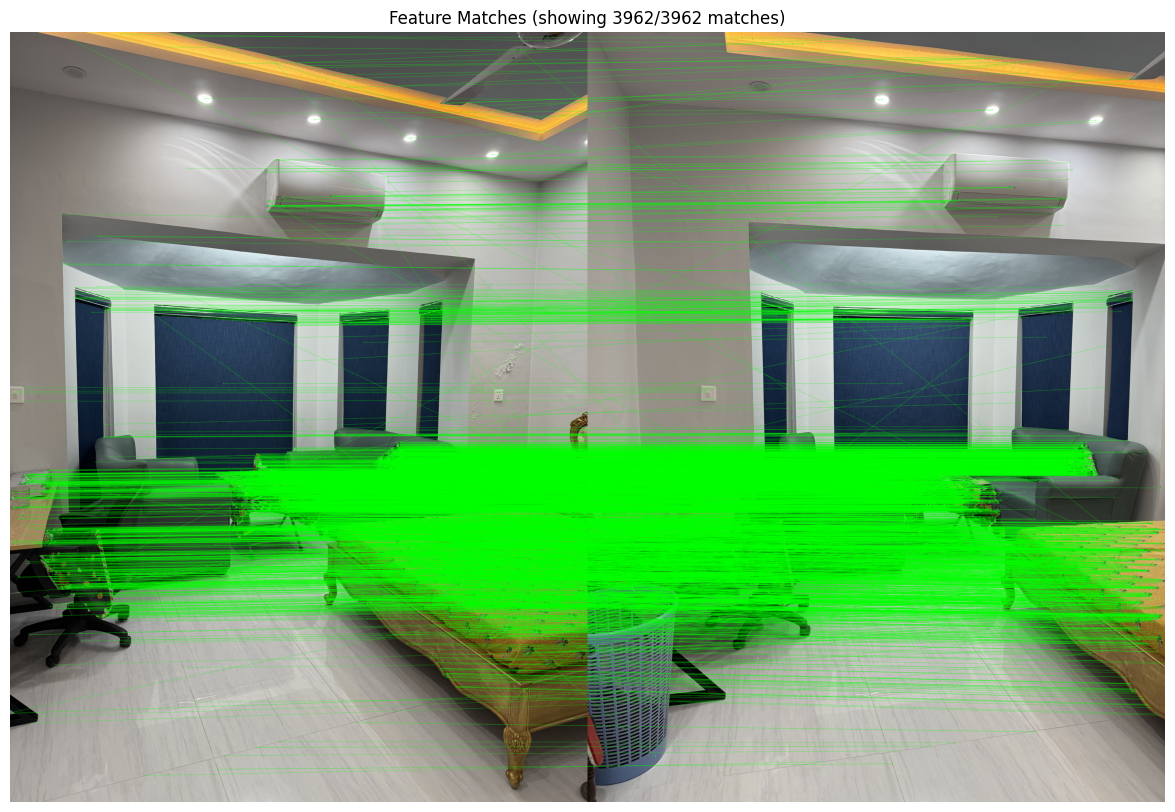

In [5]:
sift = cv2.SIFT_create()

kp1, des1 = sift.detectAndCompute(gray1, None)
kp2, des2 = sift.detectAndCompute(gray2, None)

print(f"Using SIFT feature detector")
print(f"Detected {len(kp1)} keypoints in image 1")
print(f" Detected {len(kp2)} keypoints in image 2")

FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)

flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

good_matches = []
pts1 = []
pts2 = []

ratio_threshold = 0.70

for match in matches:
    if len(match) == 2:
        m, n = match
        if m.distance < ratio_threshold * n.distance:
            good_matches.append(m)
            pts1.append(kp1[m.queryIdx].pt)
            pts2.append(kp2[m.trainIdx].pt)

pts1 = np.float32(pts1)
pts2 = np.float32(pts2)

print(f"Found {len(good_matches)} good matches")

img_matches = cv2.drawMatches(
    img1_rgb, kp1, img2_rgb, kp2, good_matches, None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
    matchColor=(0, 255, 0)
)

plt.figure(figsize=(20, 10))
plt.imshow(img_matches)
plt.title(f'Feature Matches (showing {len(good_matches)}/{len(good_matches)} matches)')
plt.axis('off')
plt.show()

## 5. Essential Matrix Estimation

Estimate the Essential Matrix using RANSAC with the matched points and camera intrinsic matrix.

In [6]:
E, mask = cv2.findEssentialMat(
    pts1, pts2, K,
    method=cv2.RANSAC,
    prob=0.999,
    threshold=1.0
)

inliers = np.sum(mask)
inlier_ratio = inliers / len(mask) * 100

pts1_inliers = pts1[mask.ravel() == 1]
pts2_inliers = pts2[mask.ravel() == 1]

print('')
print(f"After filtering: {len(pts1_inliers)}/{len(mask)}")


After filtering: 2720/3962


## 6. Camera Pose Recovery with Cheirality Check

Decompose the Essential Matrix to recover the relative camera pose (R, t) and perform cheirality check.

In [7]:
num_inliers, R, t, mask_cheirality = cv2.recoverPose(
    E, pts1_inliers, pts2_inliers, K
)

print(f"Camera pose recovered")
print(f"Points passing cheirality check: {num_inliers}/{len(pts1_inliers)}")
print(f"\nRotation matrix R:")
print(R)
print(f"\nTranslation vector t:")
print(t.ravel())

P1 = K @ np.hstack([np.eye(3), np.zeros((3, 1))])
P2 = K @ np.hstack([R, t])

points_4d_hom = cv2.triangulatePoints(P1, P2, pts1_inliers.T, pts2_inliers.T)

points_3d = points_4d_hom[:3, :] / points_4d_hom[3, :]
points_3d = points_3d.T

print(f"\nTriangulated {len(points_3d)} 3D points")

mask = mask_cheirality.ravel() == 255

points_3d_valid = points_3d[mask]
pts1_valid = pts1_inliers[mask]
pts2_valid = pts2_inliers[mask]


print(f"\nFiltered 3D points: {len(points_3d_valid)}")


Camera pose recovered
Points passing cheirality check: 2118/2720

Rotation matrix R:
[[ 6.71395710e-01  8.54759743e-03  7.41049755e-01]
 [-2.60997317e-04  9.99936150e-01 -1.12972430e-02]
 [-7.41099003e-01  7.39150851e-03  6.71355072e-01]]

Translation vector t:
[0.41519529 0.00183    0.90973047]

Triangulated 2720 3D points

Filtered 3D points: 2118


## 7. Filter Outlier Points

Remove statistical outliers based on depth and reprojection error.

In [8]:
depth_threshold = 50.0

depths = points_3d_valid[:, 2]

depth_mask = (depths > 0) & (depths < depth_threshold)

valid_depths = depths[depth_mask]
if len(valid_depths) > 0:
    q25, q75 = np.percentile(valid_depths, [25, 75])
    iqr = q75 - q25
    lower_bound = q25 - 1.5 * iqr
    upper_bound = q75 + 1.5 * iqr

    statistical_mask = (depths >= lower_bound) & (depths <= upper_bound)
else:
    statistical_mask = depth_mask

final_mask = depth_mask & statistical_mask

points_3d_final = points_3d_valid[final_mask]
pts1_final = pts1_valid[final_mask]
pts2_final = pts2_valid[final_mask]

removed = len(points_3d_valid) - len(points_3d_final)

print(f"  Removed {removed} outliers, Remaining points: {len(points_3d_final)}")
print(f"  Depth range: [{points_3d_final[:, 2].min():.2f}, {points_3d_final[:, 2].max():.2f}]")

  Removed 278 outliers, Remaining points: 1840
  Depth range: [0.50, 7.65]


## 8. 3D Point Cloud Visualization

Interactive 3D visualization of the reconstructed point cloud.

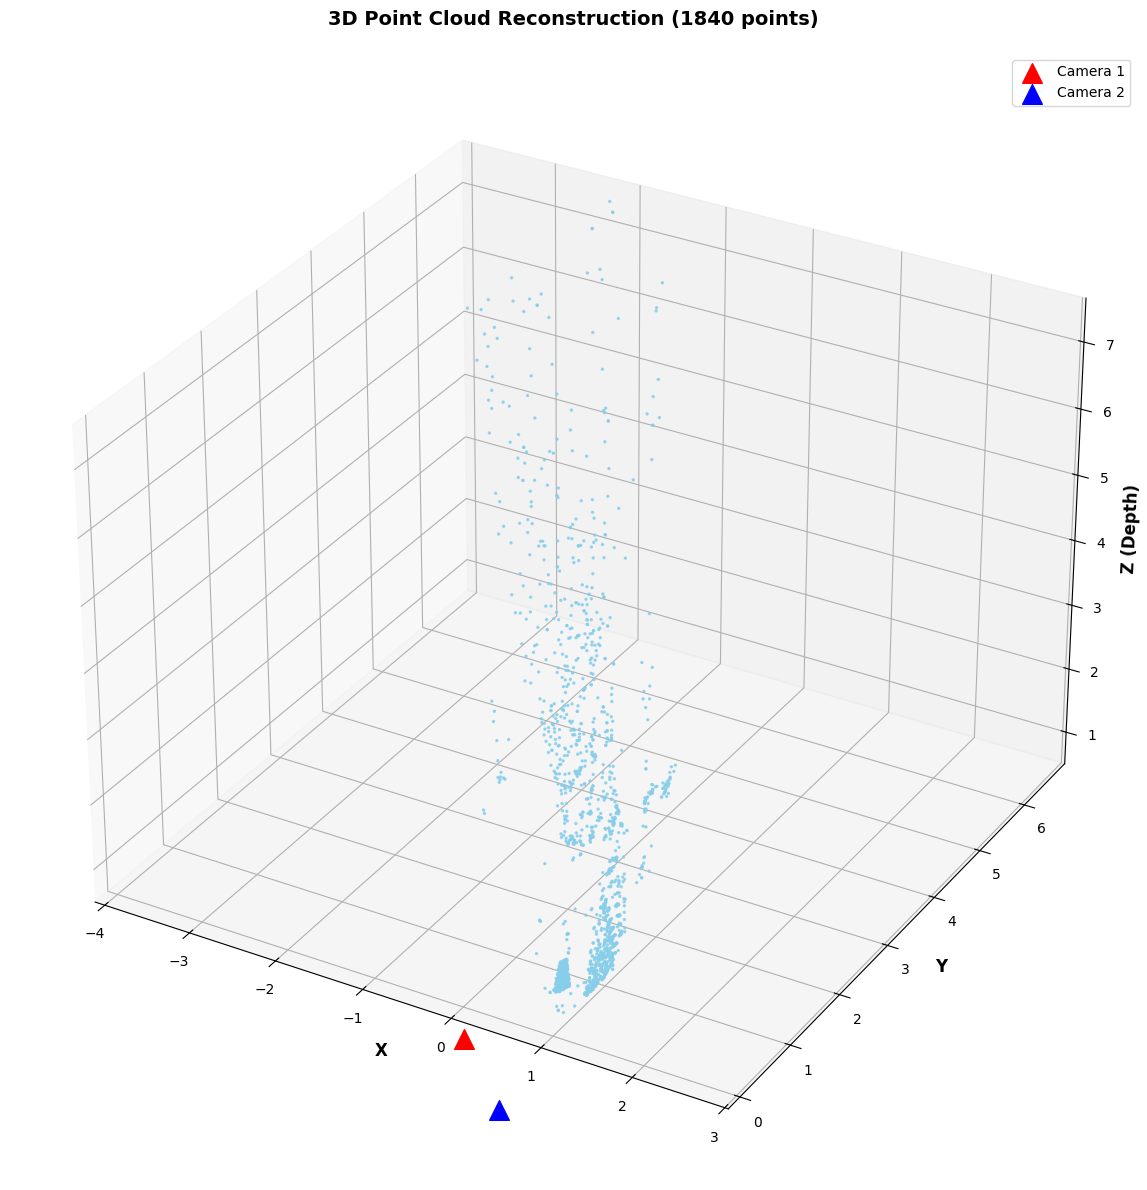

In [9]:
def visualize_3d_matplotlib(points_3d, title="3D Point Cloud"):
    fig = plt.figure(figsize=(15, 12))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(
        points_3d[:, 0],
        points_3d[:, 1],
        points_3d[:, 2],
        c='skyblue',
        marker='o',
        s=2,
        alpha=0.8
    )

    ax.scatter([0], [0], [0], c='red', marker='^', s=200, label='Camera 1')
    cam2_pos = -R.T @ t
    ax.scatter([cam2_pos[0]], [cam2_pos[1]], [cam2_pos[2]],
               c='blue', marker='^', s=200, label='Camera 2')

    ax.set_xlabel('X', fontsize=12, fontweight='bold')
    ax.set_ylabel('Y', fontsize=12, fontweight='bold')
    ax.set_zlabel('Z (Depth)', fontsize=12, fontweight='bold')
    ax.set_title(title, fontsize=14, fontweight='bold', pad=20)
    ax.legend(fontsize=10)

    max_range = np.array([
        points_3d[:, 0].max() - points_3d[:, 0].min(),
        points_3d[:, 1].max() - points_3d[:, 1].min(),
        points_3d[:, 2].max() - points_3d[:, 2].min()
    ]).max() / 2.0

    mid_x = (points_3d[:, 0].max() + points_3d[:, 0].min()) * 0.5
    mid_y = (points_3d[:, 1].max() + points_3d[:, 1].min()) * 0.5
    mid_z = (points_3d[:, 2].max() + points_3d[:, 2].min()) * 0.5

    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)

    plt.tight_layout()
    plt.show()

visualize_3d_matplotlib(
    points_3d_final,
    title=f"3D Point Cloud Reconstruction ({len(points_3d_final)} points)"
)

## 9. Export to PLY File

Save the reconstructed point cloud to a PLY file for viewing in external tools.

In [11]:
def save_ply(filename, points_3d):
    """
    Save point cloud to PLY file format without colors.
    Args:
        filename: Output filename (should end with .ply)
        points_3d: 3D points (Nx3)
    """
    with open(filename, 'w') as f:
        f.write('ply\n')
        f.write('format ascii 1.0\n')
        f.write(f'element vertex {len(points_3d)}\n')
        f.write('property float x\n')
        f.write('property float y\n')
        f.write('property float z\n')
        f.write('end_header\n')
        for point in points_3d:
            f.write(f'{point[0]:.6f} {point[1]:.6f} {point[2]:.6f}\n')
    print(f"✓ Point cloud saved to: {filename}")
    print(f"  Total points: {len(points_3d)}")
    print(f"  File size: {os.path.getsize(filename) / 1024:.2f} KB")

output_ply = 'group32.ply'
save_ply(output_ply, points_3d_final)
print(f"\n📁 You can view this file in:")
print(f"  - MeshLab (http://www.meshlab.net/)")
print(f"  - CloudCompare (https://www.cloudcompare.org/)")
print(f"  - Open3D Viewer")

✓ Point cloud saved to: group32.ply
  Total points: 1840
  File size: 50.79 KB

📁 You can view this file in:
  - MeshLab (http://www.meshlab.net/)
  - CloudCompare (https://www.cloudcompare.org/)
  - Open3D Viewer


## 10. Open3D Visualization (Interactive)

If Open3D is available, create an interactive 3D viewer.

In [12]:
print("Creating Open3D visualization...")
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points_3d_final)

coord_frame1 = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1.0, origin=[0, 0, 0])
cam2_pos = (-R.T @ t).ravel()
coord_frame2 = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1.0, origin=cam2_pos)

print("\n🎨 Opening interactive 3D viewer...")
print("   Controls:")
print("   - Left mouse: Rotate")
print("   - Right mouse: Pan")
print("   - Scroll: Zoom")
print("   - Press 'H' for help")

o3d.visualization.draw_geometries(
    [pcd, coord_frame1, coord_frame2],
    window_name="Phase 1: Two-View Reconstruction",
    width=1200,
    height=900,
    point_show_normal=False
)

Creating Open3D visualization...

🎨 Opening interactive 3D viewer...
   Controls:
   - Left mouse: Rotate
   - Right mouse: Pan
   - Scroll: Zoom
   - Press 'H' for help
